# Evidence of Sentiment Polarization and Gender Biases from over One Million Movie Comments


In this project, we'll try to answer two questions:

1. Do movie comments become sentimentally polarized overtime? 

2. Does this trend hold true for gender-related comments and there’s a disparity between male-related comments and female-related comments? 

To answer these two questions, we'll first fine-tune bert model to find the yearly change of sentiments of movie comments and use Word2Vex for cross-validation. Then we'll extract gender-related comments to see if this trend is also true for those comments. Then we would use dynamic topic modelling to find if there're stereotypes toward gender embedded in movie comments over time. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd 
import numpy as np 
import jieba # for cutting Chinese words
# sklearn machine learning and measurements packages
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import matthews_corrcoef, confusion_matrix, plot_roc_curve

# get lucem_illud
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud 

# deep learning packages for bert
import torch
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel, TrainingArguments, Trainer, pipeline
!pip install datasets
from datasets import load_metric, load_dataset

# for word2vec and dynamic topic modelling
import gensim
from gensim.models import LdaSeqModel
from gensim.models.coherencemodel import CoherenceModel
from ipywidgets import interact # for generating interactive visualization

# visualization and standard library packages
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pyLDAvis
import pyLDAvis # LDA visualization
import csv
from tqdm import tqdm
from collections import Counter

%matplotlib inline

# to avoid data leakage from testing set into the training set
RANDOM_STATE = 42
TEST_SIZE = 0.3

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /private/var/folders/c3/t518_j_930s_7b9x8rb4jr3w0000gn/T/pip-req-build-1yufxg3a
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /private/var/folders/c3/t518_j_930s_7b9x8rb4jr3w0000gn/T/pip-req-build-1yufxg3a
  Resolved git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit 9fa6f1abdc19d159d587b4017ee6897fe7a18d4d


In [3]:
# check if cuda is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## Test Sentiment Polarization Trend

### Load Dataset & Exploration

We used a dataset of over 4 million comments from a Chinese movie rating website: movie.douban.com. 

This dataset is too big for colab to deal with. So we use 25% of it for analysis. 

In [2]:
# comments = pd.read_csv('/content/drive/MyDrive/Dataset/moviedata-10m/comments.csv')
comments_dir = "/Users/mao_shiba/Desktop/2021-Content-Analysis/Movie_Comments/moviedata-10m/moviedata-10m/comments.csv"
comments = pd.read_csv(comments_dir)
comments = comments.loc[:, ['COMMENT_TIME','MOVIE_ID', 'RATING', 'CONTENT']]
comments = comments.rename(columns={'COMMENT_TIME':'comment_time',
                                    'MOVIE_ID':'movie_id',
                                    'RATING':'rating',
                                    'CONTENT':'content'})
comments

,comment_time,movie_id,rating,content
0,2018-09-05 19:42:07,5113101,2.0,480p，画质不高，黑白，y
1,2019-07-09 14:52:07,5113101,1.0,毫无看点，黑白画质，一个男人孤独的心理情景历程，疯疯癫癫，没有任何恐怖的成分，这应该是剧情片吧.
2,2010-11-05 22:15:44,3718526,3.0,上吊那裡超好笑，可惜最後報告近況的旁白大扣分
3,2010-06-20 02:12:50,3718526,NaN,上海国际电影节观摩片
4,2011-04-09 22:10:13,3718526,NaN,！
...,...,...,...,...
4428470,2018-07-08 17:48:09,26914297,5.0,歌舞精良，但是故事情节看的真是闹心。在时代的大背景下，谁都无法独善其身。
4428471,2017-01-03 17:55:35,26914297,4.0,麦金托什的25周年全部是视觉路线
4428472,2018-12-10 20:09:20,26914297,3.0,记不住里面任何一首歌，就觉得胖女孩的胳膊记忆犹新
4428473,2019-08-03 14:39:02,26914297,4.0,故事不喜欢，但是场景精致，唱段好听。


In [3]:
_, selected_idx = train_test_split(comments.index, 
                                   test_size=0.25, 
                                   random_state=RANDOM_STATE)
comments = comments.iloc[selected_idx, :]

In [4]:
comments = comments.reset_index(drop=True)
comments

,comment_time,movie_id,rating,content
0,2010-01-12 22:37:02,2071447,3.0,逻辑...结构...不想HC的同学就需要辛苦地寻找，想HC就轻松多了，一景一衫，甚是光鲜，嗯...
1,2013-10-16 23:27:11,21350570,3.0,本来要四星的，细想了一下，故事不算上等。
2,2018-04-15 10:40:42,27621666,3.0,有些不知所云，短短八十几分钟竟然多次感到坐立难安……
3,2008-07-03 13:10:34,1308050,4.0,继续申恩庆..也
4,2011-10-31 18:12:47,1428178,4.0,搞笑的动画皮
...,...,...,...,...
1107114,2019-08-15 16:20:31,26808466,3.0,只能说，再接再厉！
1107115,2017-09-07 22:11:51,6710798,5.0,很喜欢这部。替爷爷难过半小时。躺在百度云里好久没看。我觉得银娇其实只是很高兴得到了爷爷的疼爱...
1107116,2016-01-16 14:19:04,26677940,1.0,接我一星
1107117,2013-11-09 13:14:37,1309136,4.0,《惊情四百年》的另一种解读，表里城设计参考了《恶魔城 白夜协奏曲》，《上古卷轴》般的画风。总...


In [5]:
# check empty content
empty_lst = []
error_lst = []
for index, row in tqdm(comments.iterrows()):
  try:
    if not row['content'].strip():
        empty_lst.append(index)
  except AttributeError:
    error_lst.append(index)
empty_lst

1107119it [00:40, 27499.63it/s]


[145529, 416948, 489246, 1042435]

In [6]:
error_lst

[61633]

In [7]:
comments.drop(empty_lst + error_lst, axis=0, inplace=True)
comments = comments.reset_index(drop=True)
comments

,comment_time,movie_id,rating,content
0,2010-01-12 22:37:02,2071447,3.0,逻辑...结构...不想HC的同学就需要辛苦地寻找，想HC就轻松多了，一景一衫，甚是光鲜，嗯...
1,2013-10-16 23:27:11,21350570,3.0,本来要四星的，细想了一下，故事不算上等。
2,2018-04-15 10:40:42,27621666,3.0,有些不知所云，短短八十几分钟竟然多次感到坐立难安……
3,2008-07-03 13:10:34,1308050,4.0,继续申恩庆..也
4,2011-10-31 18:12:47,1428178,4.0,搞笑的动画皮
...,...,...,...,...
1107109,2019-08-15 16:20:31,26808466,3.0,只能说，再接再厉！
1107110,2017-09-07 22:11:51,6710798,5.0,很喜欢这部。替爷爷难过半小时。躺在百度云里好久没看。我觉得银娇其实只是很高兴得到了爷爷的疼爱...
1107111,2016-01-16 14:19:04,26677940,1.0,接我一星
1107112,2013-11-09 13:14:37,1309136,4.0,《惊情四百年》的另一种解读，表里城设计参考了《恶魔城 白夜协奏曲》，《上古卷轴》般的画风。总...


In [8]:
comments['comment_time'] = pd.to_datetime(comments['comment_time'])
comments = comments.set_index('comment_time').sort_index()

In [9]:
comments

,movie_id,rating,content
comment_time,,,
2005-06-12 02:22:09,1292210,4.0,重看依然很喜欢很喜欢
2005-06-12 02:22:32,1297598,5.0,唯一的一部看完后马上重看一遍的电影
2005-06-16 10:46:09,1308858,3.0,看不懂啊……
2005-06-17 15:23:55,1299539,5.0,诗一般的气息
2005-06-23 16:49:32,1292061,5.0,过瘾
...,...,...,...
2019-09-07 15:37:40,1291869,3.0,很黄很暴力，可是好没意思啊。
2019-09-07 15:41:38,4176542,4.0,值得被多重阐释的作品，就是好的作品。异类从古至今都是被诟病和排斥的。绝大多数就是对的吗？只不...
2019-09-07 15:46:44,1301173,3.0,不太喜欢女主的长相吧。


In [12]:
comments_count = pd.DataFrame(comments['content'].groupby(comments.index.year).count(), columns=['content'])                     
comments_count

,content
comment_time,
2005,401
2006,3317
2007,8551
2008,23358
2009,35809
2010,65345
2011,89136
2012,94358
2013,78033


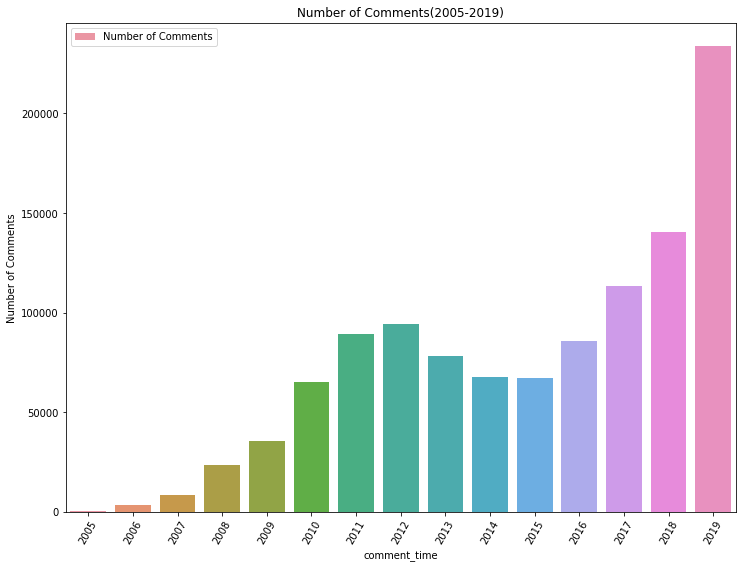

In [13]:
# plot number of comments by year
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
sns.barplot(data = comments_count,
            x = comments_count.index,
            y = 'content',
            ax=ax,
            label='Number of Comments'
            ).set_title("Number of Comments(2005-2019)")
plt.xticks(rotation=60)
plt.ylabel('Number of Comments')
plt.legend(loc = 'upper left');
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/number of comments(2005-2019).png')

#### Get labels

We need to get labels before we fine-tune a bert model for sentiment analysis. The goal is to find movies that users may like, and movies they may dislike. It is not a must-do thing to predict the accurate socres users may rate. Here we define user likes a movie if they rate 4.0 or 5.0, dislikes a movie if they rate 1.0, 2.0, or 3.0. We use 1 to denote they like a movie and 0 if dislike. Hence we labelled movie comments.

But there're some users didn’t rate the movie when they giving comments. Their ratings are NaN. Their comments could be grouped into the predicting set. These comments wouldn't be used for training and testing. 

In [14]:
def get_labels(comments):
  '''
  get labels for all comments.
  '''
  labels = []
  for x in tqdm(comments['rating']):
    if x in set((1.0, 2.0, 3.0)):
      labels.append(0)
    elif x in set((4.0, 5.0)):
      labels.append(1)
    else:
      labels.append(-1)
  return labels

comments['label'] = get_labels(comments)
comments.head()

100%|██████████| 1107114/1107114 [00:01<00:00, 1092216.51it/s]


,movie_id,rating,content,label
comment_time,,,,
2005-06-12 02:22:09,1292210,4.0,重看依然很喜欢很喜欢,1
2005-06-12 02:22:32,1297598,5.0,唯一的一部看完后马上重看一遍的电影,1
2005-06-16 10:46:09,1308858,3.0,看不懂啊……,0
2005-06-17 15:23:55,1299539,5.0,诗一般的气息,1
2005-06-23 16:49:32,1292061,5.0,过瘾,1


In [15]:
Counter(comments['label'])

Counter({-1: 64852, 0: 562759, 1: 479503})

In [16]:
comments = comments.reset_index()

In [73]:
# we don't use to_csv() here is because simply use to_csv() would yield 
# wrongly formatted csv files.
def write_csv(example_df, file_dir):
  '''
  write example DataFrame into the given file directory 
  '''
  with open(file_dir, 'w') as f:
    writer = csv.writer(f, delimiter=',')
    # write column names 
    writer.writerow(('index',
                     'comment_time',
                     'movie_id',
                     'rating',
                     'content',
                     'label'))
    for idx, row in tqdm(example_df.iterrows()):
            writer.writerow((idx,
                             row['comment_time'],
                             row['movie_id'],
                             row['rating'],
                             row['content'],
                             row['label'],))


In [17]:
# comments that don't have ratings. This dataset could be used for prediction. 
comments_pred = comments[comments['label'] == -1].reset_index(drop=True)   

file_pred = '/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/prediction_data.csv'

write_csv(comments_pred, file_pred)

64852it [00:07, 8212.96it/s]


#### Split Test, Evaluation, and Test set. 

In [18]:
# split the rest into train set and test set
train_test_comments = comments[comments['label'] != -1].reset_index(drop=True)
train_idx, test_idx = train_test_split(train_test_comments.index, 
                                       test_size=TEST_SIZE, 
                                       random_state=RANDOM_STATE)

In [19]:
train_comments = train_test_comments.iloc[train_idx, :]
Counter(train_comments['label'])

Counter({0: 394089, 1: 335494})

In [20]:
test_comments = train_test_comments.iloc[test_idx, :]
Counter(test_comments['label'])

Counter({0: 168670, 1: 144009})

In [21]:
train_comments = train_comments.reset_index(drop=True)
test_comments = test_comments.reset_index(drop=True)

file_train = '/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/train_data.csv'
file_test = '/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/test_data.csv'

write_csv(train_comments, file_train)
write_csv(test_comments, file_test)

729583it [01:28, 8207.82it/s]
312679it [00:38, 8130.16it/s]


In [22]:
train_bert_idx, eval_bert_idx = train_test_split(train_comments.index, 
                                                 test_size=TEST_SIZE, 
                                                 random_state=RANDOM_STATE)

In [23]:
train_comments_bert = train_comments.iloc[train_bert_idx, :]
Counter(train_comments_bert['label'])

Counter({0: 275855, 1: 234853})

In [24]:
eval_comments_bert = train_comments.iloc[eval_bert_idx, :]
Counter(eval_comments_bert['label'])

Counter({0: 118234, 1: 100641})

In [25]:
train_comments_bert = train_comments_bert.reset_index(drop=True)
eval_comments_bert = eval_comments_bert.reset_index(drop=True)

file_train_bert = '/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/train_data_bert.csv'
file_eval_bert = '/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/eval_data_bert.csv'

write_csv(train_comments_bert, file_train_bert)
write_csv(eval_comments_bert, file_eval_bert)

510708it [01:02, 8218.29it/s]
218875it [00:27, 8094.46it/s]


### Train Bert Model

Here we won't spend much time on hyperparamer tuning(which could be done in future development). The first priority is combining bert and other methods to cross-validate the sentiment polarization trend. 

In this section, I'll first train a Bert model on the whole training set, and conduct sentiment analysis on the test set. Mean and variance of sentiment scores will be calculated to see if the sentiment scores are becoming polarized overtime. Second, borrowing ideas from perpexity, Word2Vec will be used to help test this trend. We'll train two word2vec models using comments from two time periods. For both word2vec model and 2 time periods, we will use comments from the other time period and the word2vec model trained on this time period to see which comments are farthest to all the movie comments from the current time period. After identifying those most distinctive comments, I'll use the fine-tuned bert model to see if there's a disparity of sentiment between this two set of commments. 

The training code is from huggingface's official [Transformers tutorial](https://huggingface.co/docs/transformers/training#finetune-with-trainer).

#### Fine-tuning

In [26]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=2)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [27]:
# we don't have enough cuda memory to train a model with max_lenght of 512.
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", max_length=128, truncation=True)

In [28]:
dataset = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/train_data_bert.csv',
                                          'test': '/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/eval_data_bert.csv'})
dataset = dataset.rename_column("content", "text")
dataset = dataset.remove_columns(['index', 'comment_time','movie_id', 'rating'])
dataset

Using custom data configuration default-95590d82345bca1a


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-95590d82345bca1a/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 510708
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 218875
    })
})

In [29]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/511 [00:00<?, ?ba/s]

  0%|          | 0/219 [00:00<?, ?ba/s]

In [30]:
train_dataset = tokenized_datasets["train"].shuffle(seed=RANDOM_STATE)
eval_dataset = tokenized_datasets["test"].shuffle(seed=RANDOM_STATE)

In [31]:
# here we set batch_size=32 cause we have 24 hours time limit on Colab
# otherwise we need to resume from checkpoints many times!
training_args = TrainingArguments(output_dir="/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert", 
                                  num_train_epochs=2,
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=64,
                                  # save_strategy = "steps"
                                  # save_steps = 10000
                                  evaluation_strategy="epoch")
metric = load_metric("f1")

Downloading:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

In [32]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

***** Running training *****
  Num examples = 510708
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 31920


Epoch,Training Loss,Validation Loss,F1
1,0.535600,0.530979,0.705905
2,0.483400,0.499687,0.730732


Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert/checkpoint-500
Configuration saved in /content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert/checkpoint-1000
Configuration saved in /content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert/checkpoint-1500
Configuration saved in /content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert/checkpoint-1500/config.json
Model weights s

TrainOutput(global_step=31920, training_loss=0.5281240142975236, metrics={'train_runtime': 15293.0283, 'train_samples_per_second': 66.79, 'train_steps_per_second': 2.087, 'total_flos': 6.718646043039744e+16, 'train_loss': 0.5281240142975236, 'epoch': 2.0})

In [34]:
# del model
# del trainer
# torch.cuda.empty_cache()

In [44]:
model_dir = "/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert"
model.save_pretrained(model_dir)

Configuration saved in /content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert/pytorch_model.bin


In [45]:
model = AutoModelForSequenceClassification.from_pretrained(model_dir, num_labels=2)

loading configuration file /content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/output_bert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.

#### Sentiment Analysis on the Test Set


In [37]:
test_comments['comment_time'] = pd.to_datetime(test_comments['comment_time'])
test_comments = test_comments.set_index('comment_time').sort_index()

In [38]:
test_comments

,movie_id,rating,content,label
comment_time,,,,
2005-06-12 02:22:09,1292210,4.0,重看依然很喜欢很喜欢,1
2005-07-03 05:45:10,1297046,3.0,（長片#04）\n另一齣早期黑白片。研究巴爾扎克的大學教授。嘉芙蓮丹露早夭的姊姊（抑或妹妹）...,0
2005-07-03 15:12:26,1306448,4.0,2006/10/23_14:10 @ UA ST\n某年英國電影節\n,1
2005-07-03 20:41:00,1305713,1.0,如果唔係林海峰...,0
2005-07-03 21:34:40,1308987,2.0,笑下囉,0
...,...,...,...,...
2019-09-07 15:18:52,27073057,1.0,束焕反鲜肉联盟急先锋，光说不练嘴把式，新时代影评人管杀不管埋,0
2019-09-07 15:19:20,26277182,4.0,女儿真是太暖心了,1
2019-09-07 15:25:46,30163509,5.0,笑中带泪的片子，为了梦想奉献一切,1


In [39]:
# check number of test comments by year. 
comments_count = test_comments['content'].groupby(test_comments.index.year)\
                                             .count()
comments_count

comment_time
2005      106
2006      893
2007     2269
2008     6338
2009     9841
2010    18140
2011    25346
2012    26365
2013    21671
2014    19170
2015    18525
2016    24139
2017    32370
2018    39838
2019    67668
Name: content, dtype: int64

In [40]:
#set the model to cpu mode for evaluation
model = model.cpu()
text_classification = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [97]:
def sentiment_analysis(example_df):
  '''
  Using fine-tuned bert  model to get 
  the sentiment label

  Inputs:
    test_comments:DataFrame

  Outputs:
    sentiment_label: list of sentiment labels
  '''
  sentiment_label = []
  scores = []
  # This operation would take a very long time, 
  # so we use tqdm to reduce our anxiery :)
  for comment in tqdm(example_df['content']):
      sent = text_classification(comment)[0]
      if sent['label'] == 'LABEL_0':
        sentiment_label.append(0)
      else:
        sentiment_label.append(1)
      scores.append(sent['score'])
  return sentiment_label, scores

In [46]:
y_label, scores = sentiment_analysis(test_comments)

100%|██████████| 312679/312679 [5:51:41<00:00, 14.82it/s]


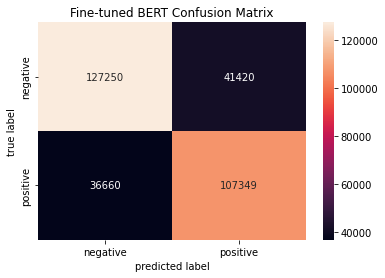

In [174]:
con_matrix_bert = confusion_matrix(test_comments['label'], y_label)
fig, ax = plt.subplots()
sns.heatmap(con_matrix_bert, annot=True, fmt='d',
            xticklabels=['negative', 'positive'], 
            yticklabels=['negative', 'positive'])
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title("Fine-tuned BERT Confusion Matrix")
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/confusion_matrix.png')

**Matthews correlation**

According to [sklearn's introduction](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), Matthews correlation coefficient could be used as a measure of the quality of classification even if the dataset is unbalanced. It ranges from -1 to 1, where 1 means perfect prediction.

Equation: 
$$ 
    MCC = \frac{TP*TN -FP*FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}
$$

In [49]:
matthews_corrcoef(test_comments['label'], y_label)

0.49889243703093944

This matthews correlation score is not bad considering the fact that we used a large batch size, only two epochs, and a max-length of 128. In general, a well fine-tuned bert model from published papers can achieve a matthews correlation score of 0.5~0.6.)

**Get ststistics**

In [50]:
def get_year_statistics(y_label, scores, cur, year_num):
    '''
    get number of positive comments, negative comments, ratio of 
    positve comments, average positive score, average negative score,
    standard variance of postive score, standard vairance of negative 
    score by year.
    '''
    label_arr = y_label[cur: cur+year_num]
    score_arr = scores[cur: cur+year_num]
    pos_lst = []
    neg_lst = []

    for label, score in tqdm(zip(label_arr, score_arr)):
        if label == 1:
            pos_lst.append(score)
        else:
            neg_lst.append(score)
    
    pos_count = len(pos_lst)
    neg_count = len(neg_lst)
    pos_ratio = pos_count/(pos_count + neg_count)
    
    pos_avg = np.mean(np.array(pos_lst))
    neg_avg = np.mean(np.array(neg_lst))
    
    pos_std = np.std(np.array(pos_lst))
    neg_std = np.std(np.array(neg_lst))

    return [pos_count, neg_count, pos_ratio, pos_avg, neg_avg, pos_std, neg_std]

In [51]:
test_comments_count = test_comments['content'].groupby(test_comments.index.year)\
                                              .count().to_list()
# start
cur = 0
year = 2005
# year = 2006
dic = {}
for year_num in test_comments_count:
    dic[year] = get_year_statistics(y_label, scores, cur, year_num)
    year += 1
    cur += year_num

106it [00:00, 870051.32it/s]
893it [00:00, 1212925.35it/s]
2269it [00:00, 2072039.14it/s]
6338it [00:00, 2102127.06it/s]
9841it [00:00, 2142768.29it/s]
18140it [00:00, 2175215.12it/s]
25346it [00:00, 2038246.62it/s]
26365it [00:00, 1688390.51it/s]
21671it [00:00, 2244813.96it/s]
19170it [00:00, 1902712.09it/s]
18525it [00:00, 2159818.81it/s]
24139it [00:00, 1940588.13it/s]
32370it [00:00, 1938707.44it/s]
39838it [00:00, 2093814.55it/s]
67668it [00:00, 2201760.69it/s]


In [52]:
df = pd.DataFrame(dic)
trend = df.stack().unstack(0)

In [53]:
trend.columns = ['positive_count', 'negative_count', 'positive_ratio', 
                 'positive_avg_score', 'negative_avg_score',
                 'positive_std', 'negative_std']
trend

,positive_count,negative_count,positive_ratio,positive_avg_score,negative_avg_score,positive_std,negative_std
2005,68.0,38.0,0.641509,0.750158,0.720211,0.135222,0.168508
2006,499.0,394.0,0.558791,0.738871,0.747674,0.145022,0.169934
2007,1266.0,1003.0,0.557955,0.736472,0.761949,0.140230,0.165964
2008,3306.0,3032.0,0.521616,0.731468,0.775891,0.138926,0.165694
2009,4951.0,4890.0,0.503099,0.732653,0.780539,0.142157,0.165884
2010,8956.0,9184.0,0.493716,0.734883,0.787194,0.140926,0.163988
2011,12351.0,12995.0,0.487296,0.739421,0.797326,0.142663,0.162106
2012,12540.0,13825.0,0.475631,0.739102,0.801101,0.142663,0.161156
2013,9861.0,11810.0,0.455032,0.740318,0.806965,0.143837,0.161291
2014,8458.0,10712.0,0.441210,0.740101,0.809517,0.143289,0.162311


In [187]:
def plot_pos_ratio(example_trend, title_name):
  '''
  polt mean and standard variance of scores of positive comments by year. 
  '''
  years = example_trend.index
  ratio = example_trend['positive_ratio']
  sns.relplot(x = years, y = ratio, kind = 'line');
  plt.title(title_name)
  plt.show()

# reference: https://stackoverflow.com/questions/56203420/how-to-use-custom-error-bar-in-seaborn-lineplot
# Matplotlib plot with custom error band

def plot_positive_avg_std(example_trend, title_name, store_name):
  '''
  polt mean and standard variance of scores of positive comments by year. 
  '''
  # Define variables to plot
  y_pos_mean = example_trend.positive_avg_score

  # Compute upper and lower bounds using chosen uncertainty measure: here
  # it is a fraction of the standard deviation of measurements at each
  # time point based on the unbiased sample variance
  pos_error = example_trend.positive_std
  pos_lower = y_pos_mean - pos_error
  pos_upper = y_pos_mean + pos_error

  # Draw plot with error band and extra formatting to match seaborn style
  fig, ax = plt.subplots(figsize=(9,5))
  ax.plot(example_trend.index, y_pos_mean, color='tab:red')
  ax.plot(example_trend.index, pos_lower, color='tab:red', alpha=0.1)
  ax.plot(example_trend.index, pos_upper, color='tab:red', alpha=0.1)
  ax.fill_between(example_trend.index, pos_lower, pos_upper, color='tab:red', alpha=0.2)
  ax.set_xlabel('Year')
  ax.set_ylabel('Positive Score')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.title(title_name)
  plt.show()
  fig.savefig(store_name)


def plot_negative_avg_std(example_trend, title_name, store_name):
  '''
    polt mean and standard variance of scores of negative comments by year.
  '''
  # Define variables to plot
  y_neg_mean = example_trend.negative_avg_score

  # Compute upper and lower bounds using chosen uncertainty measure: here
  # it is a fraction of the standard deviation of measurements at each
  # time point based on the unbiased sample variance
  neg_error = example_trend.negative_std
  neg_lower = y_neg_mean - neg_error
  neg_upper = y_neg_mean + neg_error

  # Draw plot with error band and extra formatting to match seaborn style
  fig, ax = plt.subplots(figsize=(9,5))
  ax.plot(example_trend.index, y_neg_mean)
  ax.plot(example_trend.index, neg_lower, color='tab:blue', alpha=0.1)
  ax.plot(example_trend.index, neg_upper, color='tab:blue', alpha=0.1)
  ax.fill_between(example_trend.index, neg_lower, neg_upper, alpha=0.2)
  ax.set_xlabel('Year')
  ax.set_ylabel('Negtive Score')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.title(title_name)
  plt.show()
  fig.savefig(store_name)

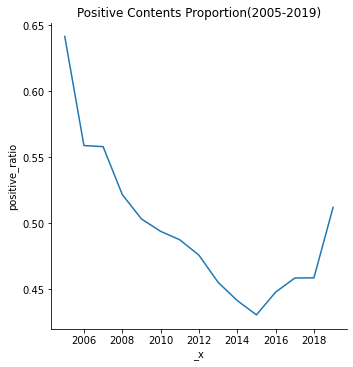

In [179]:
title_name = "Positive Contents Proportion(2005-2019)"
plot_pos_ratio(trend, title_name)

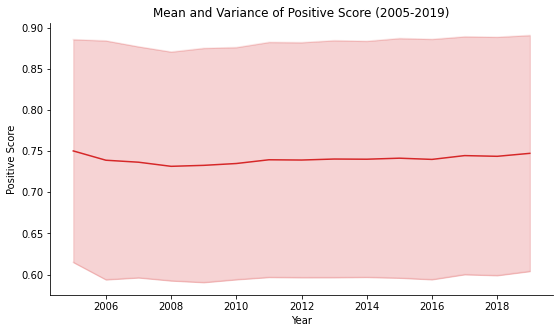

In [189]:
title_name = "Mean and Variance of Positive Score (2005-2019)"
store_name = "/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/positive_avg_std.png"
plot_positive_avg_std(trend, title_name, store_name)

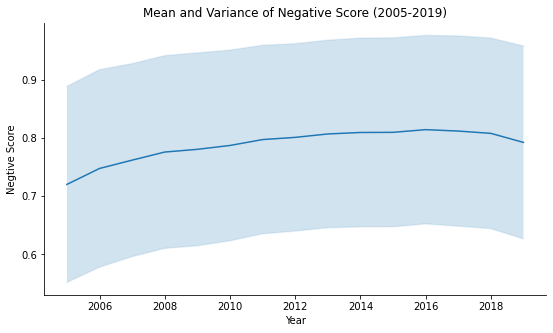

In [192]:
title_name = "Mean and Variance of Negative Score (2005-2019)"
store_name = "/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/negative_avg_std.png"
plot_negative_avg_std(trend, title_name, store_name)

### Train Word2Vec Model for Cross-Validation

#### Split Dataset into Two Time Periods

Fist let's check the number of comments by year then decide how many years should be covered in time periods. 

In [65]:
train_comments = train_comments.set_index('comment_time').sort_index()
test_comments = test_comments.set_index('comment_time').sort_index()

In [66]:
train_comments_count = pd.DataFrame(train_comments['content'].groupby(train_comments.index.year).count(), columns=['content'])                     
train_comments_count

,content
comment_time,
2005,253
2006,2108
2007,5306
2008,14938
2009,23246
2010,42794
2011,58134
2012,61524
2013,50889


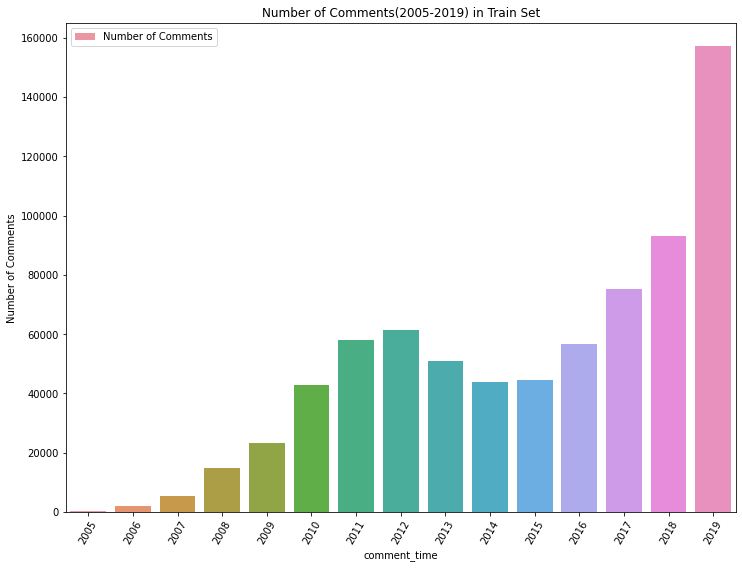

In [67]:
# plot number of comments by year
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
sns.barplot(data = train_comments_count,
            x = train_comments_count.index,
            y = 'content',
            ax=ax,
            label='Number of Comments'
            ).set_title("Number of Comments(2005-2019) in Train Set")
plt.xticks(rotation=60)
plt.ylabel('Number of Comments')
plt.legend(loc = 'upper left');
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/number of comments(2005-2019) in train set.png')

In [68]:
test_comments_count = pd.DataFrame(test_comments['content'].groupby(test_comments.index.year).count(), columns=['content'])                     
test_comments_count

,content
comment_time,
2005,106
2006,893
2007,2269
2008,6338
2009,9841
2010,18140
2011,25346
2012,26365
2013,21671


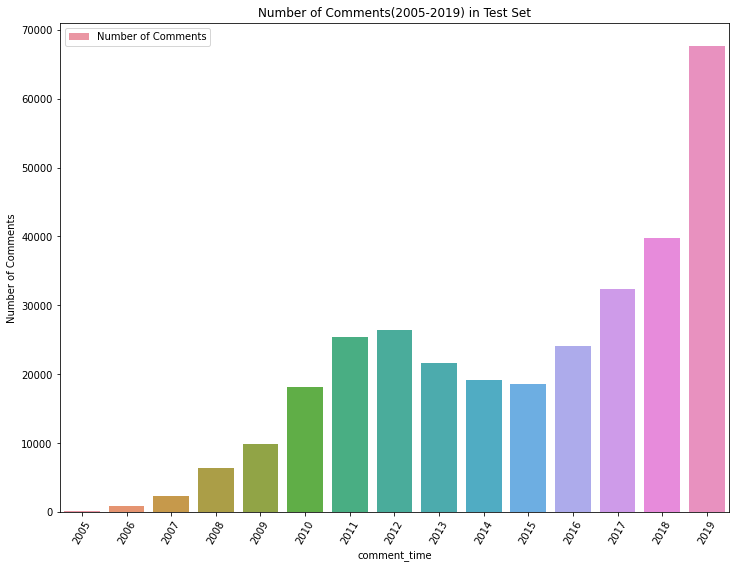

In [69]:
# plot number of comments by year
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
sns.barplot(data = test_comments_count,
            x = test_comments_count.index,
            y = 'content',
            ax=ax,
            label='Number of Comments'
            ).set_title("Number of Comments(2005-2019) in Test Set")
plt.xticks(rotation=60)
plt.ylabel('Number of Comments')
plt.legend(loc = 'upper left');
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/number of comments(2005-2019) in test set.png')

From the two figures, we can set 2005～2012 as time period 1, year 2018-2019 as time period2. We may train word2vec models with higher time granularity in future development.

In [70]:
train_w2v_comments_1 = train_comments['01/01/2005':'12/31/2012']
train_w2v_comments_2 = train_comments['01/01/2018':'12/31/2019']

test_w2v_comments_1 = test_comments['01/01/2005':'12/31/2012']
test_w2v_comments_2 = test_comments['01/01/2018':'12/31/2019']

In [72]:
# save for future use
train_w2v_comments_1 = train_w2v_comments_1.reset_index()   
file_dir_1 = '/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/w2v_data/train_w2v_comments_1.csv'
write_csv(train_w2v_comments_1, file_dir_1)
            
train_w2v_comments_2 = train_w2v_comments_2.reset_index()   
file_dir_2 = '/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/w2v_data/train_w2v_comments_2.csv'
write_csv(train_w2v_comments_2, file_dir_2)

test_w2v_comments_1 = test_w2v_comments_1.reset_index()   
file_dir_3 = '/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/w2v_data/test_w2v_comments_1.csv'
write_csv(test_w2v_comments_1, file_dir_3)

test_w2v_comments_2 = test_w2v_comments_2.reset_index()   
file_dir_4 = '/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/w2v_data/test_w2v_comments_2.csv'
write_csv(test_w2v_comments_2, file_dir_4)

208303it [00:24, 8372.90it/s]
250182it [00:30, 8147.26it/s]
89298it [00:10, 8118.31it/s]
107506it [00:13, 8231.63it/s]


#### Load Dataset and Train Word2Vec Models

In [76]:
train_w2v_comments_1 = pd.read_csv(file_dir_1, index_col='index')
train_w2v_comments_2 = pd.read_csv(file_dir_2, index_col='index')
test_w2v_comments_1 = pd.read_csv(file_dir_3, index_col='index')
test_w2v_comments_2 = pd.read_csv(file_dir_4, index_col='index')

In [77]:
train_w2v_comments_1

,comment_time,movie_id,rating,content,label
index,,,,,
0,2005-06-12 02:22:32,1297598,5.0,唯一的一部看完后马上重看一遍的电影,1
1,2005-06-16 10:46:09,1308858,3.0,看不懂啊……,0
2,2005-06-17 15:23:55,1299539,5.0,诗一般的气息,1
3,2005-06-23 16:49:32,1292061,5.0,过瘾,1
4,2005-07-03 05:31:46,1298197,5.0,（長片#07）\n2004/09/16_19:20 @ BC Cinematheque\n杜...,1
...,...,...,...,...,...
208298,2012-12-31 23:35:55,3294611,2.0,"面对人生是一种责任,是这意思吧",0
208299,2012-12-31 23:46:01,6957293,4.0,Finale让人再无话可说，全清唱组合居然真的玩出了DJ采样的感觉。舞蹈什么的我都当没看见吧...,1
208300,2012-12-31 23:46:55,19998171,3.0,最后一个故事没看进去，但前面的特别是来世不动产碉堡了！！,0


In [78]:
# replace non-chinese tokens with whitespaces
train_w2v_comments_1['content'].replace('[^\u4e00-\u9fa5A-Za-z0-9]+', ' ', regex = True, inplace=True)
train_w2v_comments_2['content'].replace('[^\u4e00-\u9fa5A-Za-z0-9]+', ' ', regex = True, inplace=True)
test_w2v_comments_1['content'].replace('[^\u4e00-\u9fa5A-Za-z0-9]+', ' ', regex = True, inplace=True)
test_w2v_comments_2['content'].replace('[^\u4e00-\u9fa5A-Za-z0-9]+', ' ', regex = True, inplace=True)

In [80]:
# adopted from source: https://github.com/goto456/stopwords/blob/master/cn_stopwords.txt
stop_words = open("/content/drive/MyDrive/Colab Notebooks/cn_stopwords customized.txt", 'r', encoding='utf-8').read()
stop_words_lst = stop_words.split('\n')
stop_words_lst[-10:]

['顺', '顺着', '首先', '！', '，', '：', '；', '？', ' ', '']

In [11]:
def cut_words(example_df, stop_words_lst):
  '''
  Tokenize Chinese using jieba 
  '''
  tokenized = []
  for _, comment in tqdm(example_df.iterrows()):
    cut_words = [text for text in jieba.lcut(comment['content']) if text not in stop_words_lst]
    tokenized.append(cut_words)
  return tokenized

In [82]:
train_w2v_comments_1['tokenized'] = cut_words(train_w2v_comments_1, stop_words_lst)
train_w2v_comments_2['tokenized'] = cut_words(train_w2v_comments_2, stop_words_lst)
test_w2v_comments_1['tokenized'] = cut_words(test_w2v_comments_1, stop_words_lst)
test_w2v_comments_2['tokenized'] = cut_words(test_w2v_comments_2, stop_words_lst)

0it [00:00, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.898 seconds.
Prefix dict has been built successfully.
208303it [01:56, 1792.59it/s]
250182it [02:44, 1516.29it/s]
89298it [00:48, 1828.96it/s]
107506it [01:11, 1514.09it/s]


In [83]:
# check empty rows and drop
empty_lst_1 = []
for index, row in tqdm(train_w2v_comments_1.iterrows()):
    if row['tokenized'] == []:
        empty_lst_1.append(index)

train_w2v_comments_1.drop(empty_lst_1, axis=0, inplace=True)

empty_lst_2 = []
for index, row in tqdm(train_w2v_comments_2.iterrows()):
    if row['tokenized'] == []:
        empty_lst_2.append(index)

train_w2v_comments_2.drop(empty_lst_2, axis=0, inplace=True)

In [90]:
doubanW2V_1 = gensim.models.word2vec.Word2Vec(train_w2v_comments_1['tokenized'].to_list(), sg=0, hs=1, negative=0)
doubanW2V_1.save("/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/w2v_model/doubanW2V_1")

doubanW2V_2 = gensim.models.word2vec.Word2Vec(train_w2v_comments_2['tokenized'].to_list(), sg=0, hs=1, negative=0)
doubanW2V_2.save("/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/w2v_model/doubanW2V_2")

doubanW2V_1 = gensim.models.Word2Vec.load("/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/w2v_model/doubanW2V_1")
doubanW2V_2 = gensim.models.Word2Vec.load("/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/w2v_model/doubanW2V_2")

/usr/local/lib/python3.7/dist-packages/gensim/utils.py:589: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  if hasattr(self, attrib):
/usr/local/lib/python3.7/dist-packages/gensim/utils.py:590: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  asides[attrib] = getattr(self, attrib)
/usr/local/lib/python3.7/dist-packages/gensim/utils.py:591: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  delattr(self, attrib)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/gensim/

#### Get Likehoods to Cross-validate Sentiment Polarization

In [85]:
# from week7's notebook
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

In [92]:
def cal_likelihood(example_df, W2V_model):
  '''
  Calculate the likelihood that comments from example_df belongs 
  to the W2V model
  '''
  likelihood_lst = []
  for _, row in tqdm(example_df.iterrows()):
    likelihood = adprob([row['tokenized']], W2V_model)
    likelihood_lst.append(likelihood)
  return likelihood_lst

In [93]:
test_w2v_comments_1['likelihood'] = cal_likelihood(test_w2v_comments_1, doubanW2V_2)
test_w2v_comments_2['likelihood'] = cal_likelihood(test_w2v_comments_2, doubanW2V_1)

89298it [01:55, 775.08it/s]
107506it [02:17, 781.22it/s]


Let's choose top 1000 most dissimilar comments from each time period.  

In [121]:
comments_from_1_different_from_2 = test_w2v_comments_1.sort_values(by = 'likelihood', ascending = True)['content'][:1000]
comments_from_2_different_from_1 = test_w2v_comments_2.sort_values(by = 'likelihood', ascending = True)['content'][:1000]

In [122]:
# create dataframes
comments_from_1_different_from_2 = pd.DataFrame(comments_from_1_different_from_2, columns=['content'])
comments_from_2_different_from_1 = pd.DataFrame(comments_from_2_different_from_1, columns=['content'])

In [123]:
y_label_1, scores_1 = sentiment_analysis(comments_from_1_different_from_2)
y_label_2, scores_2 = sentiment_analysis(comments_from_2_different_from_1)

100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]


In [124]:
def get_statistics(y_label, scores):
    '''
    get number of positive comments, negative comments, ratio of 
    positve comments, average positive score, average negative score,
    standard variance of postive score, standard vairance
    '''
    pos_lst = []
    neg_lst = []

    for label, score in tqdm(zip(y_label, scores)):
        if label == 1:
            pos_lst.append(score)
        else:
            neg_lst.append(score)
    
    pos_count = len(pos_lst)
    neg_count = len(neg_lst)
    pos_ratio = pos_count/(pos_count + neg_count)
    
    pos_avg = np.mean(np.array(pos_lst))
    neg_avg = np.mean(np.array(neg_lst))
    
    pos_std = np.std(np.array(pos_lst))
    neg_std = np.std(np.array(neg_lst))

    return [pos_count, neg_count, pos_ratio, pos_avg, neg_avg, pos_std, neg_std]

In [125]:
statistics_1 = get_statistics(y_label_1, scores_1) # comments from time period 1 
statistics_2 = get_statistics(y_label_2, scores_2) # comments from time period 2 

1000it [00:00, 1520226.17it/s]
1000it [00:00, 1583353.72it/s]


In [153]:
statistics_df = pd.DataFrame({'Comments_from_time_period_1': statistics_1,
                              'Comments_from_time_period_2': statistics_2})

In [154]:
statistics_df = statistics_df.stack().unstack(0)
statistics_df.columns = ['positive_count', 'negative_count', 'positive_ratio', 
                         'positive_avg_score', 'negative_avg_score',
                         'positive_std', 'negative_std']
statistics_df

,positive_count,negative_count,positive_ratio,positive_avg_score,negative_avg_score,positive_std,negative_std
Comments_from_time_period_1,680.0,320.0,0.680,0.779764,0.753744,0.134916,0.166126
Comments_from_time_period_2,699.0,301.0,0.699,0.793357,0.779548,0.140084,0.164323


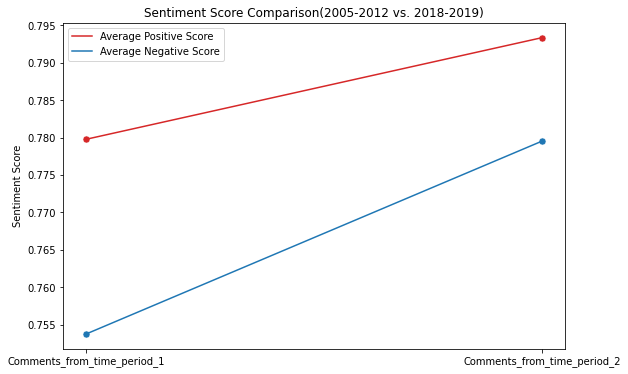

In [158]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(statistics_df.index, statistics_df.positive_avg_score,
             color='tab:red', label='Average Positive Score')
sns.scatterplot(statistics_df.index, statistics_df.positive_avg_score,
             color='tab:red', s=50)
ax.plot(statistics_df.index, statistics_df.negative_avg_score, 
             color='tab:blue', label='Average Negative Score')
sns.scatterplot(statistics_df.index, statistics_df.negative_avg_score,
             color='tab:blue', s=50)
plt.title("Sentiment Score Comparison(2005-2012 vs. 2018-2019)")
plt.ylabel('Sentiment Score')
plt.legend(loc = 'upper left')
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/Sentiment Score Comparison.png')

So although word2vec models are not trained for sentiment analysis, they also detected the polarization of sentiment. What's more, it told us that though the average positve sentiment score of all comments didn't change much overtime. Those most distinctive postive comments became polarized. Considering word2vec is a static wordembedding model and the usage of language don't change much during this two time periods, it suggested that users of douban tend to use more polarized words in thier movie comments.

## Sentiment Polarization and Stereotypes in Gender-related Comments


### Extract Gender-related Comments

Here we use key words search to extract comments that explicitly mention gender.

In [12]:
# define gender-related words.
male_related = set(['男', '他', '他的'])
female_related = set(['女', '她'])
# these words mention 'he' but are not gender-related
# noise_words = set(['其他', '他人', '他者', '顾左右而言他', '无他', '他们', '他奶奶的', '他妈的', '他娘的', '他大爷的'])

def extract_gender_related_comments(example_df, male_related, female_related):
  '''
  Extract gender related comments
  '''
  idx_male_set = set()
  idx_female_set = set()
  for idx, row in tqdm(example_df.iterrows()):
    # check if male related
    for male_word in male_related:
      if male_word == '他' or  male_word == '他的':
        if male_word in row['tokenized']:
          idx_male_set.add(idx)
          break
      else:
        if male_word in row['content']:
          idx_male_set.add(idx)
    # check if female-related
    for female_word in female_related:
      if female_word in row['content']: 
        idx_female_set.add(idx)

  intersection = idx_male_set & idx_female_set
  idx_male_set = idx_male_set - intersection
  idx_female_set = idx_female_set - intersection

  return idx_male_set, idx_female_set


In [161]:
test_comments = test_comments.reset_index()
test_comments['tokenized'] = cut_words(test_comments, stop_words_lst)
idx_male_set_test, idx_female_set_test = extract_gender_related_comments(test_comments, 
                                                                         male_related, 
                                                                         female_related)

312679it [03:17, 1582.99it/s]
312679it [00:32, 9523.40it/s] 


In [163]:
male_related_from_test = test_comments.iloc[list(idx_male_set_test), :]
female_related_from_test = test_comments.iloc[list(idx_female_set_test), :]

In [166]:
male_related_from_test

,comment_time,movie_id,rating,content,label,tokenized
196608,2017-09-25 14:27:22,1303964,3.0,有点意外评分为什么这么低，其实是蛮有意思的一部电影，恶搞香港漫画，稍微了解一点港漫应该都会觉...,0,"[有点, 意外, 评分, 低, 其实, 蛮有意思, 一部, 电影, 恶搞, 香港, 漫画, ..."
1,2005-07-03 05:45:10,1297046,3.0,（長片#04）\n另一齣早期黑白片。研究巴爾扎克的大學教授。嘉芙蓮丹露早夭的姊姊（抑或妹妹）...,0,"[（, 長, 片, #, 04, ）, \n, 齣, 早期, 黑白片, 研究, 巴爾, 扎克..."
98304,2013-06-02 14:39:23,2148243,2.0,我是真的不直答最后他选择了什么。,0,"[我, 真的, 不直, 答, 最后, 他, 选择]"
65541,2012-02-02 14:47:45,4312236,2.0,这一瞬，或许就在于车祸刹那，他转身保护着他直至死亡；那一瞬，又或许是真相大白后心灵对话，难忘...,0,"[一瞬, 或许, 车祸, 刹那, 他, 转身, 保护, 他, 直至, 死亡, 一瞬, 或许,..."
131079,2015-01-18 21:34:18,5111994,4.0,涅瓦河畔果然出盡魑魅魍魎的映像作品。本片是導演繼《契卡》之後的作品，以粉紅電影的相似時長演繹...,1,"[涅瓦河, 畔, 出盡, 魑魅, 魍, 魎, 映像, 作品, 本片, 導演繼, 契卡, 後,..."
...,...,...,...,...,...,...
262136,2019-04-11 11:40:33,1300552,4.0,超现实视角下的俯瞰，还原了恬淡的乡村生活。散文化处理消磨了冲突，无疾而终的生活由三位老人反复...,1,"[超现实, 视角, 俯瞰, 还原, 恬淡, 乡村, 生活, 散文化, 处理, 消磨, 冲突,..."
163834,2016-08-24 21:22:57,1440030,4.0,加一星，男主格外迷人,1,"[加一星, 男主, 格外, 迷人]"
131069,2015-01-18 19:37:37,6887029,5.0,#794 摄影真心美，全程柔光，心都化着。套上了好听的民谣，底子依然是科恩兄弟突破常规失控的...,1,"[#, 794, 摄影, 真心, 美, 全程, 柔光, 心都化, 套, 好听, 民谣, 底子..."
196606,2017-09-25 13:42:55,1299793,4.0,很好的电影，有些事情就是命中注定，比如咪咪的克星：脸上有三颗星的男人。很好的暗讽了当时的社会...,1,"[电影, 事情, 命中注定, 咪咪, 克星, 脸上, 三颗, 星, 男人, 暗讽, 当时, ..."


In [167]:
female_related_from_test

,comment_time,movie_id,rating,content,label,tokenized
131072,2015-01-18 19:48:53,1292479,3.0,时尚冒险娱乐闹剧 卡通童话式\n角色为主 黑白角分明 绅士与伪君子 怪杰与骗子 女性牵线 ...,0,"[时尚, 冒险, 娱乐, 闹剧, 卡通, 童话, 式, \n, 角色, 为主, 黑白, 角,..."
262148,2019-04-11 13:37:41,1304723,4.0,女主真的不好看，但是她真的演得很好。。电影结束时，新的冒险即将展开,1,"[女主, 真的, 好看, 她, 真的, 演得, 电影, 结束, 时, 新, 冒险, 即将, 展开]"
262156,2019-04-11 15:02:52,27666591,4.0,坦白讲这是一部需要静下心来看的电影，陆小雅导演作为第四代，在艺术上的表现力和镜头深度功力尽显...,1,"[坦白讲, 这是, 一部, 需要, 静下心来, 电影, 陆, 小雅, 导演, 第四代, 艺术..."
262158,2019-04-11 15:29:16,30228425,4.0,top50后平台直接托管，深度学习的素材集够了，后面算法就能基于足够的数据创造出虚拟影像，没...,1,"[top50, 平台, 直接, 托管, 深度, 学习, 素材, 集够, 后面, 算法, 足够..."
131089,2015-01-18 22:35:19,1297227,5.0,这就是为什么我不想生女儿，of which 好的那个早早没了，坏的那个一路和至亲过不去。真正...,1,"[我, 不想, 生, 女儿, of, which, 早早, 没, 坏, 一路, 至亲, 过不..."
...,...,...,...,...,...,...
262092,2019-04-11 00:12:57,27622757,3.0,胶片拍摄带来的质感和色调是非常漂亮的，四个看似独立的故事，年轻演员隆胸的渴求、新移民女人的精...,0,"[胶片, 拍摄, 带来, 质感, 色调, 非常, 漂亮, 四个, 看似, 独立, 故事, 年..."
262108,2019-04-11 02:00:18,30174107,4.0,第一部贾法·帕纳西，游刃有余的小电影。师父阿巴斯拍《十段生命的律动》，徒弟拍《出租车》，两个...,1,"[第一部, 贾法, ·, 帕, 纳西, 游刃有余, 电影, 师父, 阿巴斯, 拍, 十段, ..."
131044,2015-01-18 09:54:58,25722123,3.0,看似强硬的女人背后总会有内心的脆弱..😌,0,"[看似, 强硬, 女人, 背后, 总会, 内心, 脆弱, .., 😌]"
131047,2015-01-18 13:29:46,25872968,4.0,喜欢杨子珊这样的女生，从长相都性格都是可爱的。当然也很喜欢郑恺啦。,1,"[喜欢, 杨子, 珊, 女生, 长相, 性格, 可爱, 喜欢, 郑恺]"


Female-related comments is around 40% more than male-related.

### Test Gender-related Comments using BERT

#### Sentiment Trend of Male-related Comments

In [168]:
male_related_from_test = male_related_from_test.set_index('comment_time').sort_index()
male_related_from_test_count = male_related_from_test['content'].groupby(male_related_from_test.index.year)\
                                              .count()
male_related_from_test_count

comment_time
2005       3
2006      41
2007     111
2008     266
2009     441
2010     948
2011    1374
2012    1492
2013    1201
2014    1119
2015    1095
2016    1432
2017    1886
2018    2328
2019    3720
Name: content, dtype: int64

In [172]:
y_label_male, scores_male = sentiment_analysis(male_related_from_test)

100%|██████████| 17457/17457 [32:51<00:00,  8.85it/s]


In [173]:
# we don't have many commetns the first two years, so skip 
# start
cur = 44
year = 2007
dic = {}
male_related_from_test_count = male_related_from_test_count.to_list()
for year_num in male_related_from_test_count[2:]:
    dic[year] = get_year_statistics(y_label_male, scores_male, cur, year_num)
    year += 1
    cur += year_num

111it [00:00, 443820.54it/s]
266it [00:00, 870948.37it/s]
441it [00:00, 887992.35it/s]
948it [00:00, 1023474.95it/s]
1374it [00:00, 1185309.28it/s]
1492it [00:00, 1752422.73it/s]
1201it [00:00, 1746051.68it/s]
1119it [00:00, 1108508.78it/s]
1095it [00:00, 1310346.04it/s]
1432it [00:00, 1187239.24it/s]
1886it [00:00, 1908894.15it/s]
2328it [00:00, 1580245.95it/s]
3720it [00:00, 2248891.74it/s]


In [180]:
df2 = pd.DataFrame(dic)
trend2 = df2.stack().unstack(0)

In [181]:
trend2.columns = ['positive_count', 'negative_count', 'positive_ratio', 
                 'positive_avg_score', 'negative_avg_score',
                 'positive_std', 'negative_std']

In [207]:
trend2

,positive_count,negative_count,positive_ratio,positive_avg_score,negative_avg_score,positive_std,negative_std
2007,74.0,37.0,0.666667,0.738426,0.754154,0.136698,0.167333
2008,146.0,120.0,0.548872,0.734219,0.739608,0.138608,0.162789
2009,255.0,186.0,0.578231,0.732771,0.758863,0.133873,0.161449
2010,512.0,436.0,0.540084,0.737967,0.756965,0.140862,0.157884
2011,774.0,600.0,0.563319,0.749525,0.767546,0.146013,0.162071
2012,792.0,700.0,0.530831,0.753470,0.778678,0.141656,0.159156
2013,648.0,553.0,0.539550,0.752443,0.790678,0.140096,0.158277
2014,598.0,521.0,0.534406,0.765919,0.801224,0.144604,0.162562
2015,538.0,557.0,0.491324,0.754771,0.794618,0.146196,0.159965
2016,718.0,714.0,0.501397,0.745877,0.799416,0.142160,0.157063


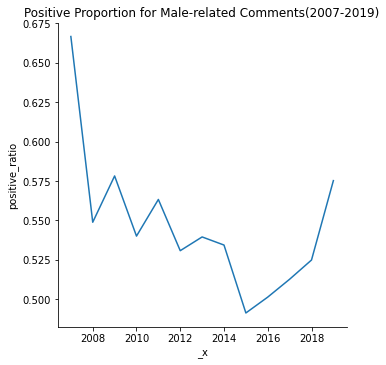

In [183]:
title_name = "Positive Proportion for Male-related Comments(2007-2019)"
plot_pos_ratio(trend2, title_name)

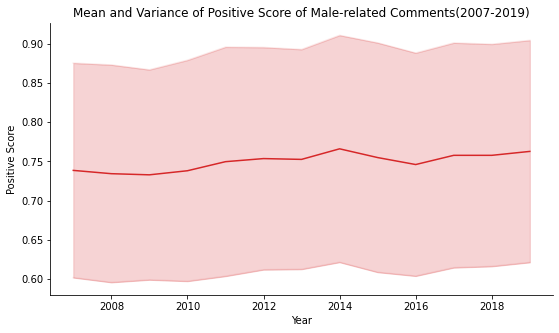

In [185]:
title_name = "Mean and Variance of Positive Score of Male-related Comments(2007-2019)"
store_name = "/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/male_positive_avg_std_.png"
plot_positive_avg_std(trend2, title_name, store_name)

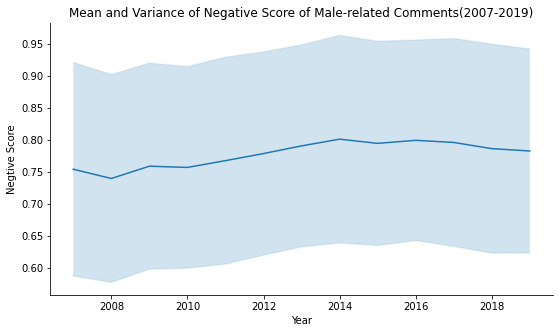

In [186]:
title_name = "Mean and Variance of Negative Score of Male-related Comments(2007-2019)"
store_name = "/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/male_negative_avg_std_.png"
plot_negative_avg_std(trend2, title_name, store_name)

#### Sentiment Trend of Female-related Comments

In [193]:
female_related_from_test = female_related_from_test.set_index('comment_time').sort_index()
female_related_from_test_count = female_related_from_test['content'].groupby(female_related_from_test.index.year)\
                                              .count()
female_related_from_test_count

comment_time
2005       8
2006      56
2007     139
2008     334
2009     587
2010    1097
2011    1725
2012    1940
2013    1741
2014    1512
2015    1493
2016    1998
2017    2729
2018    3338
2019    5023
Name: content, dtype: int64

In [194]:
y_label_female, scores_female = sentiment_analysis(female_related_from_test)

100%|██████████| 23720/23720 [38:37<00:00, 10.23it/s]


In [200]:
# we don't have many commetns the first two years, so skip 
# start
cur = 64
year = 2007
dic = {}
female_related_from_test_count = female_related_from_test_count.to_list()
for year_num in female_related_from_test_count[2:]:
    dic[year] = get_year_statistics(y_label_female, scores_female, cur, year_num)
    year += 1
    cur += year_num

139it [00:00, 528087.19it/s]
334it [00:00, 1306807.40it/s]
587it [00:00, 1686340.03it/s]
1097it [00:00, 1817200.43it/s]
1725it [00:00, 1957039.33it/s]
1940it [00:00, 1392359.64it/s]
1741it [00:00, 1903619.20it/s]
1512it [00:00, 1550938.53it/s]
1493it [00:00, 1309240.20it/s]
1998it [00:00, 1635164.76it/s]
2729it [00:00, 1632613.84it/s]
3338it [00:00, 1603549.05it/s]
5023it [00:00, 1652002.59it/s]


In [201]:
df3 = pd.DataFrame(dic)
trend3 = df3.stack().unstack(0)

In [202]:
trend3.columns = ['positive_count', 'negative_count', 'positive_ratio', 
                 'positive_avg_score', 'negative_avg_score',
                 'positive_std', 'negative_std']

In [208]:
trend3

,positive_count,negative_count,positive_ratio,positive_avg_score,negative_avg_score,positive_std,negative_std
2007,81.0,58.0,0.582734,0.738928,0.712430,0.144899,0.155238
2008,184.0,150.0,0.550898,0.711922,0.751092,0.139632,0.157352
2009,307.0,280.0,0.522998,0.725520,0.766826,0.143232,0.159460
2010,547.0,550.0,0.498633,0.728793,0.752946,0.140112,0.167515
2011,792.0,933.0,0.459130,0.737768,0.777222,0.143519,0.161692
2012,902.0,1038.0,0.464948,0.735786,0.785213,0.141147,0.160430
2013,763.0,978.0,0.438254,0.734471,0.793519,0.146816,0.160869
2014,629.0,883.0,0.416005,0.736311,0.786025,0.149891,0.168377
2015,640.0,853.0,0.428667,0.735428,0.799336,0.148225,0.158572
2016,903.0,1095.0,0.451952,0.731712,0.793488,0.147244,0.162843


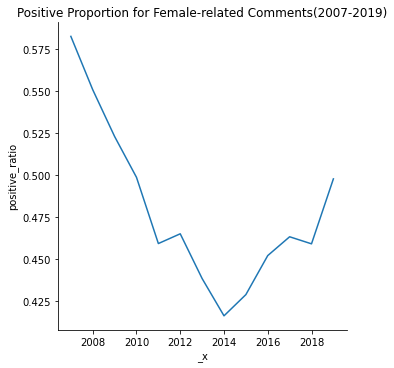

In [204]:
title_name = "Positive Proportion for Female-related Comments(2007-2019)"
plot_pos_ratio(trend3, title_name)

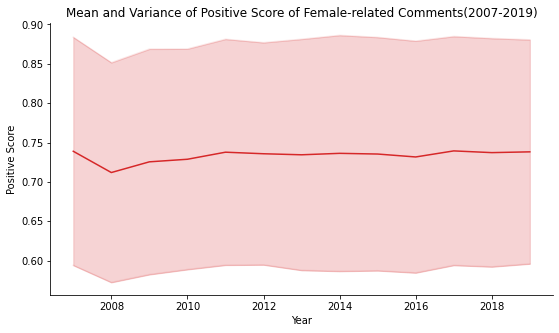

In [205]:
title_name = "Mean and Variance of Positive Score of Female-related Comments(2007-2019)"
store_name = "/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/female_positive_avg_std_.png"
plot_positive_avg_std(trend3, title_name, store_name)

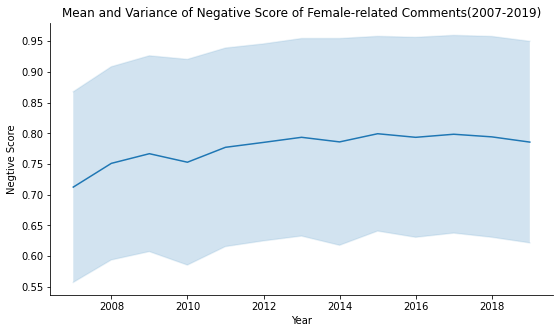

In [206]:
title_name = "Mean and Variance of Negative Score of Female-related Comments(2007-2019)"
store_name = "/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/female_negative_avg_std_.png"
plot_negative_avg_std(trend3, title_name, store_name)

#### Compare the Sentiment Trend of All Comments, Male-related Comments, and Female-related Comments

In [211]:
x = trend.index[2:]

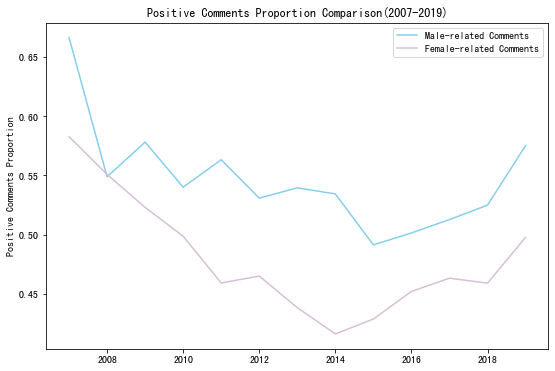

In [42]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x, trend2.positive_ratio,
        color='#87CEEB', label='Male-related Comments')
ax.plot(x, trend3.positive_ratio,
        color='#D8BFD8', label='Female-related Comments')
plt.title("Positive Comments Proportion Comparison(2007-2019)")
plt.ylabel('Positive Comments Proportion')
plt.legend(loc = 'upper right')
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/Comparison_Potivie_proportion_male_female.png')

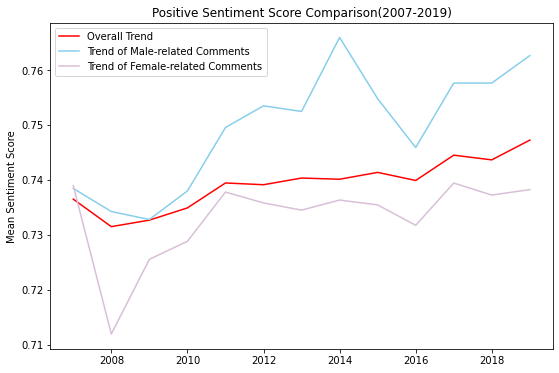

In [225]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x, trend.positive_avg_score[2:],
        color='#FF0000', label='Overall Trend')
ax.plot(x, trend2.positive_avg_score,
        color='#87CEEB', label='Trend of Male-related Comments')
ax.plot(x, trend3.positive_avg_score,
        color='#D8BFD8', label='Trend of Female-related Comments')
plt.title("Positive Sentiment Score Comparison(2007-2019)")
plt.ylabel('Mean Sentiment Score')
plt.legend(loc = 'upper left')
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/Comparison_Potivie_all_male_female.png')

So the average positve score of male-related comments is always higher than the overall trend, while the average of positve score of female-related comments is always lower than the overall trend.

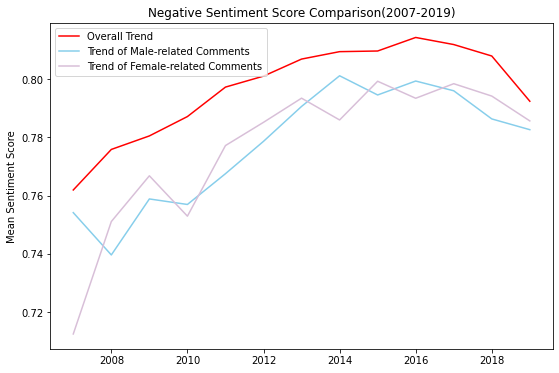

In [226]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(x, trend.negative_avg_score[2:],
        color='#FF0000', label='Overall Trend')
ax.plot(x, trend2.negative_avg_score,
        color='#87CEEB', label='Trend of Male-related Comments')
ax.plot(x, trend3.negative_avg_score,
        color='#D8BFD8', label='Trend of Female-related Comments')
plt.title("Negative Sentiment Score Comparison(2007-2019)")
plt.ylabel('Mean Sentiment Score')
plt.legend(loc = 'upper left')
fig.savefig('/content/drive/MyDrive/Colab Notebooks/Content_analysis_final/vis/Comparison_Negative_all_male_female.png')

### Dynamic Topic Modeling of Female-related Comments

In [14]:
comments = comments.reset_index()

In [13]:
# adopted from source: https://github.com/goto456/stopwords/blob/master/cn_stopwords.txt
stop_words = open("cn_stopwords customized.txt", 'r', encoding='utf-8').read()
stop_words_lst = stop_words.split('\n')

In [15]:
comments

,comment_time,movie_id,rating,content
0,2005-06-12 02:22:09,1292210,4.0,重看依然很喜欢很喜欢
1,2005-06-12 02:22:32,1297598,5.0,唯一的一部看完后马上重看一遍的电影
2,2005-06-16 10:46:09,1308858,3.0,看不懂啊……
3,2005-06-17 15:23:55,1299539,5.0,诗一般的气息
4,2005-06-23 16:49:32,1292061,5.0,过瘾
...,...,...,...,...
1107109,2019-09-07 15:37:40,1291869,3.0,很黄很暴力，可是好没意思啊。
1107110,2019-09-07 15:41:38,4176542,4.0,值得被多重阐释的作品，就是好的作品。异类从古至今都是被诟病和排斥的。绝大多数就是对的吗？只不...
1107111,2019-09-07 15:46:44,1301173,3.0,不太喜欢女主的长相吧。
1107112,2019-09-07 15:54:04,3771562,2.0,哈？好恶心哦！


In [17]:
comments['content'].replace('[^\u4e00-\u9fa5A-Za-z0-9]+', ' ', regex = True, inplace=True)
comments['tokenized'] = cut_words(comments, stop_words_lst)
_, idx_female_set_all = extract_gender_related_comments(comments, 
                                                        male_related, 
                                                        female_related)

1107114it [07:55, 2329.33it/s]
1107114it [00:59, 18525.95it/s]


In [21]:
female_related_all =comments.iloc[list(idx_female_set_all), :]
female_related_all =female_related_all.set_index('comment_time').sort_index()
female_related_all

,movie_id,rating,content,tokenized
comment_time,,,,
2005-07-07 20:31:13,1291879,3.0,看不下去啊看不下去啊女主角太丑,"[看不下去, 看不下去, 女主角, 太丑]"
2005-07-12 13:16:21,1306397,5.0,朱的推介 女孩可愛得叫人心也融化 看她哭我便要哭了,"[朱, 推介, 女孩, 可愛得, 人心, 融化, 她, 哭, 我, 便, 哭]"
2005-07-12 22:17:04,1300031,3.0,年青的 淡淡的 最後女主角帶著一疊書離開一幕很深刻,"[年青, 淡淡的, 後, 女主角, 帶著, 一疊書, 離開, 一幕, 深刻]"
2005-07-12 23:48:22,1301692,5.0,Helena Bonham Carter最美的時候 她是英國古裝電影的代表人物,"[Helena, Bonham, Carter, 最美, 時候, 她, 英國, 古裝, 電影..."
2005-07-13 11:01:21,1299655,2.0,真係 有時d野唔係靚仔靚女做真係唔好睇架,"[真, 係, 有時, d, 野, 唔, 係, 靚, 仔靚, 女, 做, 真, 係, 唔, 睇..."
...,...,...,...,...
2019-09-07 14:57:53,27063867,1.0,一星给死库水 女主好丑啊 不要再消费熊了,"[一星, 死, 库水, 女主, 好丑, 不要, 消费, 熊]"
2019-09-07 15:09:20,26667010,4.0,不仅要设法掌控日益增长 极不稳定的力量 更要与自己内心的恶魔抗争 她的失控让整个X战警大家庭...,"[设法, 掌控, 日益增长, 极, 稳定, 力量, 更要, 自己, 内心, 恶魔, 抗争, ..."
2019-09-07 15:16:51,26667010,3.0,大家好 她是琴 灭霸都是弟弟,"[大家, 她, 琴, 灭霸, 弟弟]"


In [22]:
# drop empty rows for the training process
empty_lst_all = []
for index, row in female_related_all.iterrows():
    if row['tokenized'] == []:
        empty_lst_all.append(index)
empty_lst_all

[]

In [23]:
female_related_all.drop(empty_lst_all, axis=0, inplace=True)
female_related_all

,movie_id,rating,content,tokenized
comment_time,,,,
2005-07-07 20:31:13,1291879,3.0,看不下去啊看不下去啊女主角太丑,"[看不下去, 看不下去, 女主角, 太丑]"
2005-07-12 13:16:21,1306397,5.0,朱的推介 女孩可愛得叫人心也融化 看她哭我便要哭了,"[朱, 推介, 女孩, 可愛得, 人心, 融化, 她, 哭, 我, 便, 哭]"
2005-07-12 22:17:04,1300031,3.0,年青的 淡淡的 最後女主角帶著一疊書離開一幕很深刻,"[年青, 淡淡的, 後, 女主角, 帶著, 一疊書, 離開, 一幕, 深刻]"
2005-07-12 23:48:22,1301692,5.0,Helena Bonham Carter最美的時候 她是英國古裝電影的代表人物,"[Helena, Bonham, Carter, 最美, 時候, 她, 英國, 古裝, 電影..."
2005-07-13 11:01:21,1299655,2.0,真係 有時d野唔係靚仔靚女做真係唔好睇架,"[真, 係, 有時, d, 野, 唔, 係, 靚, 仔靚, 女, 做, 真, 係, 唔, 睇..."
...,...,...,...,...
2019-09-07 14:57:53,27063867,1.0,一星给死库水 女主好丑啊 不要再消费熊了,"[一星, 死, 库水, 女主, 好丑, 不要, 消费, 熊]"
2019-09-07 15:09:20,26667010,4.0,不仅要设法掌控日益增长 极不稳定的力量 更要与自己内心的恶魔抗争 她的失控让整个X战警大家庭...,"[设法, 掌控, 日益增长, 极, 稳定, 力量, 更要, 自己, 内心, 恶魔, 抗争, ..."
2019-09-07 15:16:51,26667010,3.0,大家好 她是琴 灭霸都是弟弟,"[大家, 她, 琴, 灭霸, 弟弟]"


In [26]:
female_related_all_count = female_related_all['content'].groupby(female_related_all.index.year)\
                                              .count()
female_related_all_count = pd.DataFrame(female_related_all_count, columns=['content'])

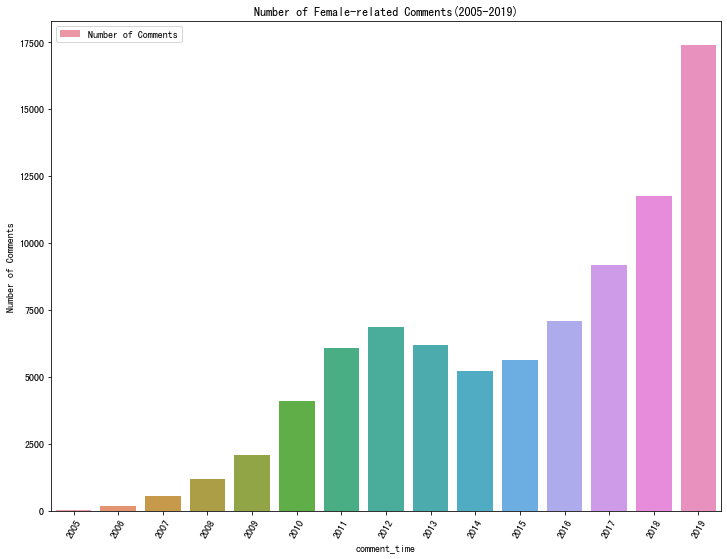

In [27]:
# plot number of female-related comments by year
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
sns.barplot(data = female_related_all_count,
            x = female_related_all_count.index,
            y = 'content',
            ax=ax,
            label='Number of Comments'
            ).set_title("Number of Female-related Comments(2005-2019)")
plt.xticks(rotation=60)
plt.ylabel('Number of Comments')
plt.legend(loc = 'upper left');
fig.savefig('Number of Female-related Comments(2005-2019).png')

In [30]:
# get time slices 
time_slice_0 = female_related_all['01/01/2005':'12/31/2009']['tokenized']\
                                           .groupby(female_related_all['01/01/2005':'12/31/2009'].index.year)\
                                           .count()\
                                           .sum()

time_slice_rest = female_related_all['01/01/2010':'12/31/2019']['tokenized']\
                                           .groupby(female_related_all['01/01/2010':'12/31/2019'].index.year)\
                                           .count()\
                                           .to_list()

time_slices = [time_slice_0] + time_slice_rest
for idx, time_slice in enumerate(time_slices):
    print('time_slice{}: {}'.format(idx, time_slice))

time_slice0: 3997
time_slice1: 4103
time_slice2: 6059
time_slice3: 6850
time_slice4: 6181
time_slice5: 5214
time_slice6: 5619
time_slice7: 7082
time_slice8: 9160
time_slice9: 11751
time_slice10: 17404


In [32]:
# prepare corpus
corpus = list(female_related_all['tokenized'].values)
dictionary = gensim.corpora.Dictionary(corpus)
bow_corpus = [dictionary.doc2bow(text) for text in corpus]

# check length
sum(time_slices) == len(corpus)

True

Apart from codes from week3 topic modeling notebook, some of the following parts of codes(mainly pyLDAvis visualization, and some lines codes in the get_coherence_socre function) are adapted from codes distributed by Professor Clindaniel (MACSS staff, The University of Chicago) in his MACS 30124 class. Thanks!

In [ ]:
# In this case, the total training process is more than 72 hours...
# don't have to re-run this again. 

from tqdm import tqdm

def get_coherence_score(bow_corpus, dictionary, time_slices,
                        start_topic_num=2, end_topic_num=20, step=2):
    '''
    Finging suitable number of topics using coherence socre(criteria: u_mass)
    attention: every round of training would take more than 2 hours! 
    
    Inputs:
      bow_corpus: gensim bow_corpus generated by using doc2bow
      dictionary: gensim dictionary
      time_slices: a list where every element is the number of comments in each time slice  
      start_topic_num: start topics number 
      end_topic_num: end topics number 
      step: step for changing number of topics
      
    Outputs:
      coherence_score_lst: a list of average coherence socres. 
    '''
    coherence_score_lst = []
    for num_topics in tqdm(range(start_topic_num, end_topic_num, step)):
        # training 
        ldaseq = LdaSeqModel(corpus=bow_corpus, 
                             id2word=dictionary, 
                             time_slice=time_slices, 
                             num_topics=num_topics)
        ldaseq.save("lda_models/ldaseq_top{}.model".format(num_topics))
        loaded_models = LdaSeqModel.load("lda_models/ldaseq_top{}.model".format(num_topics))
        
        # get coherence socre
        avg_coherence_score = 0
        for t in range(len(time_slices)):      
            topics_dtm = loaded_models.dtm_coherence(t)
            cm_DTM = CoherenceModel(topics=topics_dtm,
                                    corpus=bow_corpus,
                                    dictionary=dictionary,
                                    coherence='u_mass')
            avg_coherence_score += cm_DTM.get_coherence()
        avg_coherence_score = avg_coherence_score/len(time_slices)
        coherence_score_lst.append(avg_coherence_score)
    return coherence_score_lst


coherence_score_lst = get_coherence_score(bow_corpus=bow_corpus, 
                                          dictionary=dictionary, 
                                          time_slices=time_slices,
                                          start_topic_num=2, 
                                          end_topic_num=16, 
                                          step=2)

In [36]:
coherence_score_lst = []
for i in range(2, 16, 2):
    loaded_models = LdaSeqModel.load("lda_models/ldaseq_top{}.model".format(i))
    
    # get coherence socre
    avg_coherence_score = 0
    for t in range(len(time_slices)):      
        topics_dtm = loaded_models.dtm_coherence(t)
        cm_DTM = CoherenceModel(topics=topics_dtm,
                                corpus=bow_corpus,
                                dictionary=dictionary,
                                coherence='u_mass')
        avg_coherence_score += cm_DTM.get_coherence()
    avg_coherence_score = avg_coherence_score/len(time_slices)
    coherence_score_lst.append(avg_coherence_score)

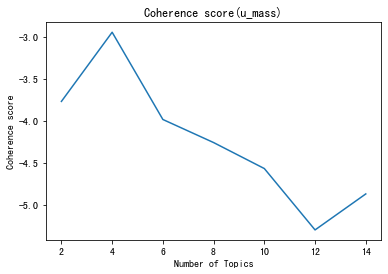

In [37]:
# plot coherence score
plt.plot(range(2, 16, 2), coherence_score_lst)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Coherence score(u_mass)");
plt.savefig("coherence_score_for_dynamic_topic_modeling.png")

In [38]:
num_topics = 4
loaded_models = LdaSeqModel.load("lda_models/ldaseq_top{}.model".format(num_topics))

In [40]:
# Create pyLDAvis visualization
pyLDAvis.enable_notebook()

vis = {}
dates = pd.Series(['2005~2009', '2010', '2011', '2012', '2013',
                   '2014', '2015', '2016', '2017', '2018', '2019'])
for i in range(len(dates)):
    doc_topic, topic_term, doc_lengths, term_frequency, vocab = loaded_models.dtm_vis(time=i, corpus=bow_corpus)
    vis[dates[i]] = pyLDAvis.prepare(topic_term_dists=topic_term,
                                     doc_topic_dists=doc_topic,
                                     doc_lengths=doc_lengths,
                                     vocab=vocab,
                                     term_frequency=term_frequency)

# Make an interactive plot
@interact(dates=dates)
def f(dates):
    return vis[dates]

for i, date in enumerate(dates):
   pyLDAvis.save_html(vis[dates[i]], 'lda_vis/time_slice{}_date_{}.html'.format(i, date))

/Users/mao_shiba/opt/anaconda3/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(Dropdown(description='dates', options=('2005~2009', '2010', '2011', '2012', '2013', '201…

# Conclusion

Our two hypotheses are largely correct. But there're also some disagreements. Evidence from over one million movie commemnts on Douban support the the claim that the overall trend of sentiment polarization. This polarization is temporal polarization but not geographical polarization. Not users are divided into two parts, but all the users tend to expresess more extreme feelings in movie comments. And this overall trend is validated by 2 Word2Vec models. We also found the biases in gender-related comments. We found a consistent pattern of higher proportion of positive comments and also average positive score in male-related comments compared to female-related comments. Finally, we conducted dynamic topic modelling on female-related comments. Though the performance is not good, the results from dynamic topic modelling may suggest that we tend to foucus less on the appearance of actresses, but more on the quality of movies where those actresses were in.